# Sentiment Analysis: Customer Feedback

# Notebook 5.1: BERT Transformer Model

In this notebook, customer feedback/comments/reviews are analyzed to determine whether they are positive, negative, or neutral using the BERT (Bidirectional Encoder Representations from Transformers) model.

## Setup

In [1]:
import os

# libraries to work with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

# libraries for machine learning
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

C:\Users\ASUS\anaconda3\envs\hexsoftwares_ml_env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


PyTorch with CUDA 12.1 is installed for a computer that supports CUDA 13.0.

```console
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
```

In [2]:
# check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f"CUDA version: {torch.version.cuda}")    
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f'Memory Usage: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

GPU: NVIDIA GeForce GTX 1060
CUDA version: 12.1
Number of GPUs: 1
Memory Usage: 6.00 GB
Using device: cuda


## Loading Clean Datasets

In [3]:
df_train = pd.read_pickle('./datasets/final_training_dataset.pkl')
df_train

,review_text,sentiment
0,wow love place,1
1,crust not good,0
2,not tasti textur nasti,0
3,stop late may bank holiday rick steve recommen...,1
4,select menu great price,1
...,...,...
25895,disappoint qualiti,0
25896,amaz experi highli recommend,1
25897,fast deliveri great packag,1
25898,great valu money,1


In [4]:
df_test = pd.read_pickle('./datasets/final_testing_dataset.pkl')
df_test

,review_text,sentiment
0,fantast spot even quit cocktail swell host yel...,1
1,love love love calamari good spici endless lis...,1
2,love place stiff martini cocktail cheap drink ...,1
3,everyth great cocktail bar great locat ambianc...,1
4,come pirat game around 530ish even get lucki t...,1
...,...,...
4316,wife catch show golden nugget hear good thing ...,0
4317,dumb show ever seen never laugh minut realiz w...,0
4318,girlfriend go show absolut terriblenot funni n...,0
4319,restroom look like bombard improvis shack amid...,0


## BERT: Data Splitting

The training dataset is split into features (X) and target (y). Each of these is further divided into a training set (X_train, y_train) and a validation set (X_val, y_val) to evaluate the model's generalization ability. A separate test set (X_test, y_test) is kept aside and does not need further division.

The **labels (y)** in the training, validation, and test datasets **must be integers** for multi-class classification.

In [5]:
# features and labels for the training dataset
X = df_train['review_text'].values  # raw text, not vectorized # np array
y = df_train['sentiment'].values.astype(int)  # convert to integers

# split the training dataset into validation dataset
raw_X_train, raw_X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# features and labels for the testing dataset
raw_X_test = df_test['review_text'].values  # raw text, not vectorized # np array
y_test = df_test['sentiment'].values.astype(int)  # convert to integers

# check the shape and data type of the datasets before and after splitting
elements = {
    "X": X,
    "raw_X_train": raw_X_train,
    "raw_X_val": raw_X_val,
    "raw_X_test": raw_X_test,
    "y": y,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test
}

for name, element in elements.items():
    print(f"{name} shape: {element.shape}")
    print(f"{name} data type: {element.dtype}\n")

X shape: (25900,)
X data type: object

raw_X_train shape: (20720,)
raw_X_train data type: object

raw_X_val shape: (5180,)
raw_X_val data type: object

raw_X_test shape: (4321,)
raw_X_test data type: object

y shape: (25900,)
y data type: int64

y_train shape: (20720,)
y_train data type: int64

y_val shape: (5180,)
y_val data type: int64

y_test shape: (4321,)
y_test data type: int64



After splitting the dataset, the class distributions for the training and validation datasets should be similar since they come from the same dataset. The test dataset, however, can have a different distribution as it comes from a completely separate dataset, which is acceptable in real-world scenarios.

In [6]:
# get distributions
train_dist = Counter(y_train)
val_dist = Counter(y_val)
test_dist = Counter(y_test)

# calculate totals
train_total = len(y_train)
val_total = len(y_val)
test_total = len(y_test)

# print to compare distributions with percentages
print("training dataset label distribution:")
for label, count in sorted(train_dist.items()):
    percentage = (count / train_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {train_total:,}")

print("\nvalidation dataset label distribution:")
for label, count in sorted(val_dist.items()):
    percentage = (count / val_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {val_total:,}")

print("\ntesting dataset label distribution:")
for label, count in sorted(test_dist.items()):
    percentage = (count / test_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {test_total:,}")

training dataset label distribution:
  (Class 0): 8271 (39.92%)
  (Class 1): 8369 (40.39%)
  (Class 2): 4080 (19.69%)
  Total: 20,720

validation dataset label distribution:
  (Class 0): 2070 (39.96%)
  (Class 1): 2105 (40.64%)
  (Class 2): 1005 (19.40%)
  Total: 5,180

testing dataset label distribution:
  (Class 0): 1332 (30.83%)
  (Class 1): 2989 (69.17%)
  Total: 4,321


## BERT: Encoding

BERT requires tokenization using its specific tokenizer. The tokenizer converts text into tokens that BERT can understand.

The `BertTokenizer` is a text preprocessing method from the `transformers` library. It is used to **transform a collection of review texts into sequences of subword tokens**, represented as integer IDs that BERT can understand. The process is as follows:
- `from_pretrained()`: Loads a pre-trained tokenizer with a vocabulary learned from a large corpus (does not require training on the dataset).
- `encode_plus()`: Converts text into token IDs, attention masks, and other BERT-specific inputs in a single step.
- `encode()`: Converts text into token IDs only.

***

Each text is converted into a sequence of integer token IDs, where each integer represents a subword token (not necessarily a whole word) from BERT's vocabulary. The tokenizer uses **WordPiece tokenization**, which splits words into smaller subword units when necessary. This allows BERT to **handle out-of-vocabulary words by breaking them into known subword pieces**.

Example: Given a review "this is not good":
- "this is not good" → tokenized into subwords → [101, 2023, 2003, 2025, 2204, 102]
  - `101` = [CLS] token (classification token, added at the beginning)
  - `2023` = "this"
  - `2003` = "is"
  - `2025` = "not"
  - `2204` = "good"
  - `102` = [SEP] token (separator token, added at the end)
- row: "this is not good"
- column: [101, 2023, 2003, 2025, 2204, 102] (sequence of token IDs)

For words not in the vocabulary, they are split into subwords:
- "unhappiness" → ["un", "##happiness"] → [2162, 12913]
  - `##` indicates this is a subword continuation

***

It **requires padding and truncation** because it creates <u>variable-length</u> sequences (not fixed-size vectors) for each review. The length of each sequence is determined by the number of subword tokens in that review. To make all sequences the same length for the BERT model, the `max_length` parameter is used to either:
- **Pad** shorter sequences (with zeros typically at the end, after the [SEP] token)
- **Truncate** longer sequences (removing tokens from the end, keeping the [CLS] token at the beginning)

Example: If `max_length = 8`:
- "this is not good" → [101, 2023, 2003, 2025, 2204, 102, 0, 0] (padded with zeros)
- "this is a very long review that exceeds the maximum length" → [101, 2023, 2003, 2079, 2200, 2146, 2023, 102] (truncated)

> Note: `max_len` is set to 80 to match the RNN model configuration for fair comparison.

***

The tokenizer also **returns an attention mask**, which is a binary vector indicating which tokens are real (1) and which are padding (0). This allows BERT to ignore padding tokens during processing.

Example: For the padded sequence above:
- Token IDs: [101, 2023, 2003, 2025, 2204, 102, 0, 0]
- Attention mask: [1, 1, 1, 1, 1, 1, 0, 0] (1 = real token, 0 = padding)

***

Unlike bag-of-words methods, BERT tokenization **preserves word order** and **context** through the sequence structure. The [CLS] token at the beginning is used for classification tasks, as BERT's final hidden state of this token contains a representation of the entire sequence. The [SEP] token is used to separate different segments (useful for tasks like question-answering, but for single-sentence classification, it simply marks the end of the input).

Example:
- "this is not good" → [101, 2023, 2003, 2025, 2204, 102]
- "good is not this" → [101, 2204, 2003, 2025, 2023, 102]

These produce different sequences, allowing BERT to distinguish between different word orders, unlike bag-of-words methods which would treat them identically.

***

The tokenizer also performs **lowercasing** and **basic normalization** by default (for `bert-base-uncased`), converting all text to lowercase and handling special characters. This ensures consistency with the pre-trained BERT model's training data format.

In [7]:
# disable warnings (optional)
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [8]:
MAX_LENGTH = 80  # maximum sequence length for BERT
MODEL_NAME = 'bert-base-uncased'  # base BERT model

# load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# example
sample_text = "This is a example to be encoded/tokenized"
encoded = tokenizer.encode_plus(
    sample_text,
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

print(f"Sample text: '{sample_text}'")
print(f"Token IDs shape: {encoded['input_ids'].shape}")
print(f"Token IDs: {encoded['input_ids'][0][:20].tolist()}...")  # Show first 20 tokens
print(f"Attention mask: {encoded['attention_mask'][0][:20].tolist()}...")  # Show first 20 masks

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 0aa2bd77-c813-46c4-b6c4-7e5309ca57a3)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


Sample text: 'This is a example to be encoded/tokenized'
Token IDs shape: torch.Size([1, 80])
Token IDs: [101, 2023, 2003, 1037, 2742, 2000, 2022, 12359, 1013, 19204, 3550, 102, 0, 0, 0, 0, 0, 0, 0, 0]...
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]...


In TensorFlow, tokenization is typically done upfront on all data at once, producing arrays/tensors that can be fed directly to the model:
```python
X_train_sequences = tokenizer.texts_to_sequences(raw_X_train)
X_train = pad_sequences(X_train_sequences, maxlen=MAX_LEN, padding='post')
```

However, PyTorch uses a different approach. PyTorch's Dataset/DataLoader pattern tokenizes on-the-fly (lazy evaluation), which means tokenization happens during training rather than upfront. This approach is more flexible but requires writing a Dataset class to handle tokenization and data loading efficiently.

### (a) Helper Function

In [9]:
class SentimentDataset(Dataset):
    """PyTorch Dataset for sentiment analysis"""
    
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

### (b) Applying Helper Function

In [10]:
# create datasets
X_train = SentimentDataset(raw_X_train, y_train, tokenizer, MAX_LENGTH)
X_val = SentimentDataset(raw_X_val, y_val, tokenizer, MAX_LENGTH)
X_test = SentimentDataset(raw_X_test, y_test, tokenizer, MAX_LENGTH)

# define batch size
BATCH_SIZE = 16

# create data loaders
train_loader = DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(X_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(X_test, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 1295
Validation batches: 324
Test batches: 271


## BERT: Model Configuration

BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based model that uses bidirectional context to understand language. In this project, the base BERT model is used for sequence classification with 3 output classes.

In [11]:
# load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3  # number of classes
)

# move model to device
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The optimizer is responsible for updating the model's parameters during training to minimize the loss function.

The `AdamW` or "Adam with Weight Decay" optimizer is an improved version of the Adam optimizer that combines adaptive learning rates with proper weight decay regularization. It adjusts the learning rate for each parameter based on a moving average of gradients and squared gradients, similar to Adam, but applies weight decay directly to the parameters rather than incorporating it into the gradient calculation. This approach leads to better generalization and is particularly effective for transformer models like BERT.

***

The learning rate is set to `2e-5` (0.00002), which is a standard value for fine-tuning pre-trained BERT models. This relatively small learning rate is chosen because BERT is already pre-trained on a large corpus, so only small adjustments are needed to adapt it to the specific task. Using a larger learning rate could cause the model to "forget" its pre-trained knowledge, while a smaller rate might result in insufficient learning.

***

The epsilon parameter (`eps=1e-8`) is a small value added to the denominator during optimization to prevent division by zero. This is a standard default value that ensures numerical stability.

In [12]:
# setup optimizer
LEARNING_RATE = 2e-5
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# calculate total training steps
total_steps = len(train_loader) * EPOCHS

# create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [13]:
# display model information
print(f"Model loaded: {MODEL_NAME}")
print(f"Model device: {next(model.parameters()).device}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Total training steps: {total_steps}")

# count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model loaded: bert-base-uncased
Model device: cuda:0
Learning rate: 2e-05
Total training steps: 3885
Total parameters: 109,484,547
Trainable parameters: 109,484,547


## BERT: Model Training & Evaluation

### (a) Helper Functions

In [14]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    progress_bar = tqdm(data_loader, desc='Training')
    
    for batch in progress_bar:
        # move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # calculate accuracy
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predictions == labels)
        total_samples += labels.size(0)
        total_loss += loss.item()
        
        # update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': correct_predictions.double() / total_samples
        })
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / total_samples
    
    return avg_loss, accuracy.item()

In [15]:
def eval_model(model, data_loader, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc='Evaluating')
        
        for batch in progress_bar:
            # move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            # calculate accuracy
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(predictions == labels)
            total_samples += labels.size(0)
            total_loss += loss.item()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # update progress bar
            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': correct_predictions.double() / total_samples
            })
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / total_samples
    
    return avg_loss, accuracy.item(), all_predictions, all_labels

### (b) Applying Helper Functions

In [16]:
# training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
patience = 2
patience_counter = 0

print("Starting training...")
print()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 60)
    
    # train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    
    # validate
    val_loss, val_acc, _, _ = eval_model(model, val_loader, device)
    
    # save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"\ntrain loss: {train_loss:.4f}, train accuracy: {train_acc:.4f}")
    print(f"val loss: {val_loss:.4f}, val accuracy: {val_acc:.4f}")
    
    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()  # save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            model.load_state_dict(best_model_state)
            break

print()
print("Training completed!")

Starting training...


Epoch 1/3
------------------------------------------------------------


Training: 100%|█| 1295/1295 [09:53<00:00,  2.18it/s, loss=0.0019, acc=tensor(0.9862, device='cuda:0', dtype=torch.float
Evaluating: 100%|█| 324/324 [00:53<00:00,  6.02it/s, loss=0.000162, acc=tensor(0.9948, device='cuda:0', dtype=torch.flo



train loss: 0.0485, train accuracy: 0.9862
val loss: 0.0161, val accuracy: 0.9948

Epoch 2/3
------------------------------------------------------------


Training: 100%|█| 1295/1295 [10:26<00:00,  2.07it/s, loss=8.36e-5, acc=tensor(0.9982, device='cuda:0', dtype=torch.floa
Evaluating: 100%|█| 324/324 [00:53<00:00,  6.08it/s, loss=4.92e-5, acc=tensor(0.9958, device='cuda:0', dtype=torch.floa



train loss: 0.0061, train accuracy: 0.9982
val loss: 0.0225, val accuracy: 0.9958

Epoch 3/3
------------------------------------------------------------


Training: 100%|█| 1295/1295 [10:09<00:00,  2.13it/s, loss=5.29e-5, acc=tensor(0.9998, device='cuda:0', dtype=torch.floa
Evaluating: 100%|█| 324/324 [00:54<00:00,  5.91it/s, loss=3.62e-5, acc=tensor(0.9963, device='cuda:0', dtype=torch.floa



train loss: 0.0011, train accuracy: 0.9998
val loss: 0.0270, val accuracy: 0.9963

Early stopping triggered after 3 epochs

Training completed!


## BERT: Loss & Accuracy

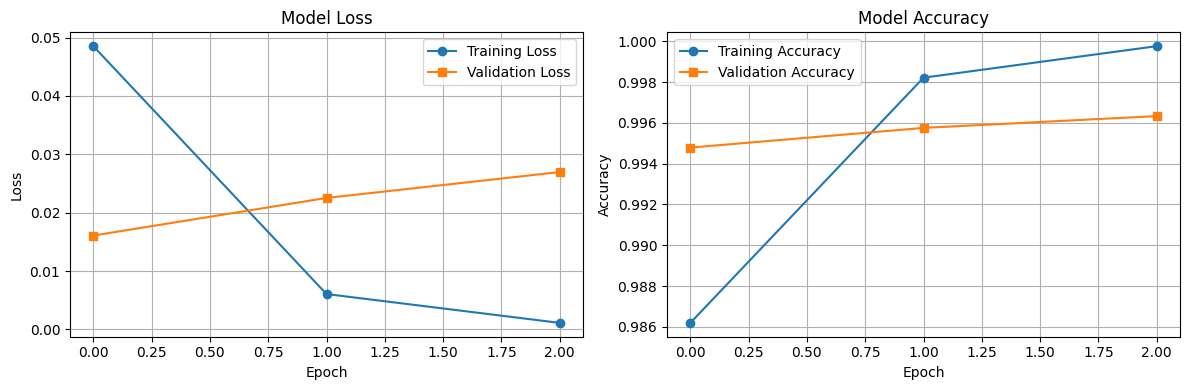

In [17]:
# plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# loss plot
axes[0].plot(history['train_loss'], label='Training Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True)

# accuracy plot
axes[1].plot(history['train_acc'], label='Training Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## BERT: Model Testing

The fine-tuned BERT model is evaluated on the testing dataset after training is complete. The validation dataset is used during training to monitor performance, tune hyperparameters, and implement early stopping. The testing dataset is reserved during training for final evaluation to provide an unbiased estimate of the model’s generalization performance on unseen data.

In [18]:
## actual labels
class_names = []

## get unique classes (integers)
classes = sorted(df_train['sentiment'].unique())

## map integers to actual labels
for c in classes:
    if c == 0:
        class_names.append("Negative")
    elif c == 1:
        class_names.append("Positive")
    elif c == 2:
        class_names.append("Neutral")

print(f"class names: {class_names}")

class names: ['Negative', 'Positive', 'Neutral']


In [19]:
# evaluate on test set
test_loss, test_acc, y_pred, y_true = eval_model(model, test_loader, device)

# evaluate scores
test_accuracy = accuracy_score(y_true, y_pred)
test_f1_macro = f1_score(y_true, y_pred, average='macro')
test_f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"loss on test data: {test_loss:.4f}")
print(f"accuracy on test data: {test_accuracy:.6f}")
print(f"F1-macro on test data: {test_f1_macro:.6f}")
print(f"F1-weighted on test data: {test_f1_weighted:.6f}")

# classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=[0, 1, 2], target_names=class_names, zero_division=0))

Evaluating: 100%|█| 271/271 [00:39<00:00,  6.78it/s, loss=9.25, acc=tensor(0.8586, device='cuda:0', dtype=torch.float64

loss on test data: 0.8243
accuracy on test data: 0.858598
F1-macro on test data: 0.842588
F1-weighted on test data: 0.861839

Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.88      0.79      1332
    Positive       0.94      0.85      0.89      2989
     Neutral       0.00      0.00      0.00         0

    accuracy                           0.86      4321
   macro avg       0.55      0.58      0.56      4321
weighted avg       0.87      0.86      0.86      4321



## BERT: Confusion Matrix

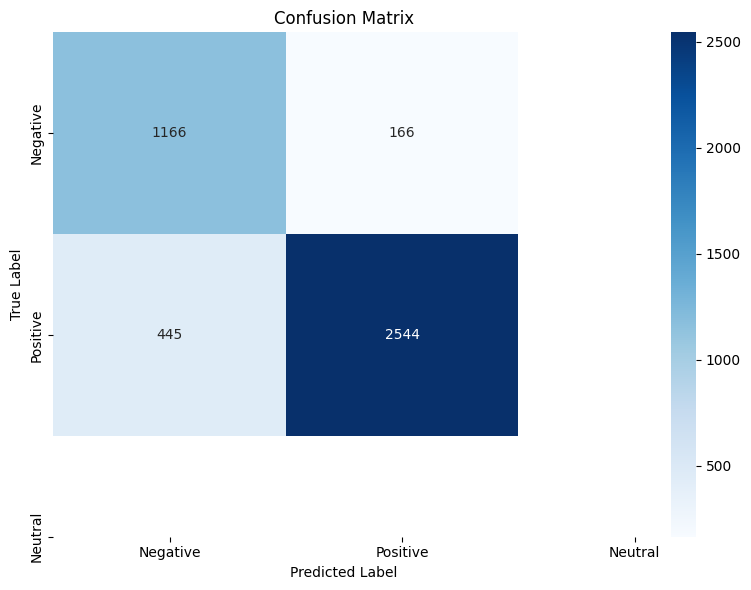

In [20]:
# compute a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Overall, the model demonstrates strong generalization on unseen data, with consistently high performance across evaluation metrics. The confusion matrix shows that the model is particularly effective at identifying positive instances, while performance on the negative class is comparatively weaker, indicating a mild prediction bias toward the positive label.

##  BERT: Model Testing with Any Reviews

In [21]:
def predict_sentiment(text, model, tokenizer, device):
    """Predict sentiment for a single text"""
    model.eval()
    
    # tokenize
    encoding = tokenizer.encode_plus(
        text,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
    
    # get prediction
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0][predicted_class].item()
    all_probs = probabilities[0].cpu().numpy()
    
    return predicted_class, confidence, all_probs

In [22]:
review_to_predict = str(input("Enter a review: "))
prediction, confidence, prediction_probs = predict_sentiment(review_to_predict, model, tokenizer, device)

if prediction == 0:
    print(f"\nPrediction: {class_names[0]}")
elif prediction == 1:
    print(f"\nPrediction: {class_names[1]}")
elif prediction == 2:
    print(f"\nPrediction: {class_names[2]}")

print(f"\nProbabilities: {class_names[0]}: {prediction_probs[0]:.4f}, "
          f"{class_names[1]}: {prediction_probs[1]:.4f}, "
          f"{class_names[2]}: {prediction_probs[2]:.4f}")

Enter a review: very costly and dirty

Prediction: Negative

Probabilities: Negative: 0.9998, Positive: 0.0001, Neutral: 0.0000


## BERT: Saving Model

In [23]:
model.save_pretrained('./models/sentiment_analysis_bert_model_pytorch')

This notebook is done by `La Wun Nannda`.